#### boston 데이터셋 활용 집값 예측 모델
- 데이터셋 : boston.csv
- 구현프레임워크 : Pytorch

- [1] 모듈 로딩 및 데이터 준비

In [15]:
# 모듈 로딩
import torch                        # 텐서 및 수치 계산 함수 관련 모듈
import torch.nn as nn               # 인공신경망 관련 모듈
import torch.nn.functional as F     # 손실, 거래 등 함수 관련 모듈
import torch.optim as optimizer     # 최적화 기법 관련 모듈

import pandas as pd                 # 데이터 파일 분석 관련 모듈
from sklearn.model_selection import train_test_split

In [16]:
# 데이터 로딩 : CSV => DataFrame
DATA_FILE=pd.read_csv('../data/boston.csv')
bostonDF=pd.DataFrame(DATA_FILE)

# 시드 설정
torch.manual_seed(10)

In [17]:
bostonDF.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.9,9.14,21.6


[2] 모델 준비
- 학습방법 : 지도학습 > 회귀
- 알고리즘 : 선형관계 >> 선형모델 nn.Linear 

In [18]:
# in_features : petal.length 1개
# out_features : peral.width 1개
model=nn.Linear(len(bostonDF.columns[:-1]), 1)

nn_model=nn.Sequential(nn.Linear(3,10),
                       nn.ReLU(),
                       nn.Linear(10,50),
                       nn.ReLU(),
                       nn.Linear(50,1))
                   

In [19]:
# 가중치와 절편 확인
for name, param in model.named_parameters():
    print(f'[{name}] {param}\n')

[weight] Parameter containing:
tensor([[-0.0233, -0.0095, -0.1040,  0.0638, -0.1587, -0.0489,  0.1075,  0.2603,
          0.0653, -0.0941,  0.0266, -0.0311,  0.1132]], requires_grad=True)

[bias] Parameter containing:
tensor([0.0318], requires_grad=True)



[3] 최적화 인스턴스 준비

In [20]:
# 모델의 가중치와 절편을 최적화 => 인스턴스에 전달
adam_optim=optimizer.Adam(model.parameters(), lr=0.1)

[4] 학습 => 개발자가 구현

- [4-1] 데이터셋 Tensor화 진행 : 데이터준비 시 진행하거나 학습 전 진행

In [21]:
bostonDF.columns[:-1]

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

In [22]:
featureTS=torch.from_numpy(bostonDF[bostonDF.columns[:-1]].values).float()
featureTS.shape

torch.Size([506, 13])

In [23]:
targetTS=torch.from_numpy(bostonDF[['MEDV']].values).float()
targetTS.shape

torch.Size([506, 1])

In [24]:
# Train & Test
X_train, X_test, y_train, y_test=train_test_split(featureTS, targetTS, test_size=0.2, random_state=5)

# Train & Valid
X_train, X_val, y_train, y_val=train_test_split(featureTS, targetTS, test_size=0.2, random_state=5)

print(f'TRAIN {X_train.shape}, TEST {X_test.shape}, VAL {X_val.shape}')
print(f'TRAIN {y_train.shape}, TEST {y_test.shape}, VAL {y_val.shape}')

TRAIN torch.Size([404, 13]), TEST torch.Size([102, 13]), VAL torch.Size([102, 13])
TRAIN torch.Size([404, 1]), TEST torch.Size([102, 1]), VAL torch.Size([102, 1])


- [4-2] 학습진행
    * 학습횟수 결정 => 에포크 설정
    * 학습결과 저장 => 손실저장 변수

In [25]:
EPOCH=10

In [26]:
# 테스트/검증 함수
# => 가중치, 절편 업데이트 X, 최적화 미진행
# => 현재 가중치와 절편값으로 테스트 진행
# 모델 학습 함수
def testing(testTS, targetTS, kind='Val'):

    val_history=[]
    
    with torch.no_grad(): # 가중치 및 절편 업데이트 진행 X
        # (1) 학습진행 : forward
        pre_y=model(testTS)

        # (2) 오차계산 : 손실함수
        loss=F.mse_loss(pre_y, targetTS)
        
        # (3) 학습결과 출력 및 저장
        print(f'[{kind}] LOSS : {loss}')
    
    return loss

In [27]:
# 모델 학습 함수
def training(featureTS, targetTS, valTS, valTargetTS):

    loss_history=[[],[]]
    
    for epoch in range(EPOCH):
        # (1) 학습진행 : forward
        pre_y=model(featureTS)

        # (2) 오차계산 : 손실함수
        loss=F.mse_loss(pre_y, targetTS)
        loss_history[0].append(loss.item())

        # (3) 최적화 : 가중치, 절편 업데이트 backward
        adam_optim.zero_grad()
        loss.backward()
        adam_optim.step()
        
        # (4) 검증 : 모델이 제대로 만들어 지는지 검사용
        val_loss=testing(valTS, valTargetTS)
        loss_history[1].append(val_loss.item())

        # (5) 학습결과 출력 및 저장
        print(f'[{epoch}/{EPOCH}] LOSS : {loss}')
        
    return loss_history

In [28]:
# 모델 학습 진행
loss=training(X_train, y_train, X_val, y_val)

[Val] LOSS : 987.4348754882812
[0/10] LOSS : 4126.33642578125
[Val] LOSS : 3394.17431640625
[1/10] LOSS : 972.1162719726562
[Val] LOSS : 1400.9705810546875
[2/10] LOSS : 3319.177978515625
[Val] LOSS : 75.6837158203125
[3/10] LOSS : 1379.6829833984375
[Val] LOSS : 1000.2086181640625
[4/10] LOSS : 97.6689682006836
[Val] LOSS : 1751.6314697265625
[5/10] LOSS : 1014.8463745117188
[Val] LOSS : 1087.03759765625
[6/10] LOSS : 1749.4132080078125
[Val] LOSS : 198.97634887695312
[7/10] LOSS : 1088.769287109375
[Val] LOSS : 204.676025390625
[8/10] LOSS : 211.66001892089844
[Val] LOSS : 806.5531005859375
[9/10] LOSS : 217.8325958251953


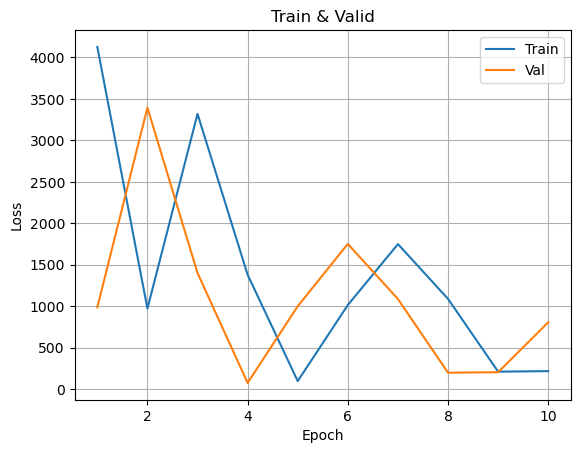

In [29]:
# 학습 후 loss 시각화
import matplotlib.pyplot as plt

plt.plot(range(1,11),loss[0], label='Train')
plt.plot(range(1,11),loss[1], label='Val')
plt.title('Train & Valid')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()